#Section 1 - Data load, manipulation and preprocessing functions


##Section 1.1 - Load libraries and data

In [1]:
%tensorflow_version 2.x
import matplotlib.pyplot as plt
import rpy2
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import statsmodels.api as sma
from datetime import datetime,tzinfo
from tensorflow.python.keras.layers import LSTM
from tensorflow.python.keras.layers import GRU
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dropout
from tensorflow.python.keras.layers import RNN
from tensorflow.python.keras.layers import Bidirectional
from tensorflow.python.keras import optimizers
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.callbacks import EarlyStopping
from tensorflow.python.keras.callbacks import ModelCheckpoint
from tensorflow.python.keras.callbacks import ReduceLROnPlateau
from tensorflow.python.keras.layers import Flatten
from tensorflow.python.keras.layers import BatchNormalization
from tensorflow.python.keras.layers import RepeatVector
from tensorflow.python.keras.layers import TimeDistributed
from tensorflow.python.keras.models import load_model
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import linear_model
from datetime import date
import calendar
from numpy import array
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import math
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
import rpy2.robjects as robjects
import rpy2.robjects.numpy2ri
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr
from tensorflow.python.keras.utils.vis_utils import plot_model
from IPython.display import Image

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex
/usr/local/lib/python3.6/dist-packages/rpy2/robjects/pandas2ri.py:34: UserWarning: pandas >= 1.0 is not supported.
  warnings.warn('pandas >= 1.0 is not supported.')


In [0]:
#Random function seed is set to 0 in case we need to reproduce results
np.random.seed(0)

In [0]:
#Set numpy to print proper float values instead of e multiplications
np.set_printoptions(suppress=True)

In [0]:
#Load R/Python library
rpy2.robjects.numpy2ri.activate()
pandas2ri.activate()

In [5]:
#Connect to drive where datasets are stored
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#Suppress chained_assignment warnings from showing during some computations
pd.set_option('mode.chained_assignment', None)

In [0]:
#Change from float32 to float64, some RNN computations prefer float64(based on warnings shown)
tf.keras.backend.set_floatx('float64')

In [0]:
#Load datasets used into respective pandas dataframes
traffic = pd.read_csv('/content/drive/My Drive/BP2/Metro_Interstate_Traffic_Volume.csv')
electricity_consumption = pd.read_csv('/content/drive/My Drive/BP2/AEP_hourly.csv')

##Section 1.2 - Functions for preprocessing, input/output creation functions

In [0]:
#Checking data set for stationarity by using the Augmented Dickey-Fuller and Kwiatkowski–Phillips–Schmidt–Shin tests
def stationarity_test(data):
    test_df = adfuller(data, autolag='AIC')
    test_kpss = kpss(data, regression='c', lags='auto')
    results_df = pd.Series(test_df[0:4], index=['Test Statistic', 'p-value', 'Lags Used', 'Number of Observations Used'])
    results_kpss = pd.Series(test_kpss[0:3], index=['Test Statistic', 'p-value', 'Lags Used'])
    for key, value in test_df[4].items():
       results_df['Critical Value(%s)'%key]=value
    print('ADF test results:')
    print(results_df)
    for key, value in test_kpss[3].items():
      results_kpss['Critical Value(%s)'%key]=value
    print('KPSS test results:')
    print(results_kpss)

In [0]:
#run this for multivariate input with attributes temp, traffic_volume and clouds_all
def multivariate_traffic_data(traffic_train, traffic_test, traffic_train_arima, traffic_test_arima):
  print(traffic_train.shape, traffic_test.shape)
  traffic_scaler_temp = MinMaxScaler(feature_range=(0, 1))
  traffic_scaler_volume = MinMaxScaler(feature_range=(0, 1))

  #Fit scaler on training data
  traffic_train['traffic_volume'] = traffic_scaler_volume.fit_transform(np.asarray(traffic_train['traffic_volume']).reshape(-1, 1))
  #Transform the rest of data
  traffic_test['traffic_volume'] = traffic_scaler_volume.transform(np.asarray(traffic_test['traffic_volume']).reshape(-1, 1))
  traffic_train_arima = traffic_scaler_volume.transform(np.asarray(traffic_train_arima).reshape(-1, 1))
  traffic_test_arima = traffic_scaler_volume.transform(np.asarray(traffic_test_arima).reshape(-1, 1))

  traffic_train_labels = traffic_train['traffic_volume'].values
  traffic_test_labels = traffic_test['traffic_volume'].values
  traffic_train = traffic_train.values
  traffic_test = traffic_test.values
  return traffic_train, traffic_test, traffic_train_labels, traffic_test_labels, traffic_scaler_volume, traffic_train_arima, traffic_test_arima

In [0]:
def multivariate_eletricity_data(train_electricity, test_electricity, train_electricity_arima, test_electricity_arima):
  print(train_electricity.shape, test_electricity.shape)
  electricity_target_scaler = MinMaxScaler(feature_range=(0, 1))

  #Fit scaler on training data
  train_electricity['AEP_MW'] = electricity_target_scaler.fit_transform(np.asarray(train_electricity['AEP_MW']).reshape(-1, 1))
  #Transform the rest of data
  test_electricity['AEP_MW'] = electricity_target_scaler.transform(np.asarray(test_electricity['AEP_MW']).reshape(-1, 1))
  train_electricity_arima = electricity_target_scaler.transform(np.asarray(train_electricity_arima).reshape(-1, 1))
  test_electricity_arima = electricity_target_scaler.transform(np.asarray(test_electricity_arima).reshape(-1, 1))

  train_electricity_labels = train_electricity['AEP_MW'].values
  test_electricity_labels = test_electricity['AEP_MW'].values
  train_electricity = train_electricity.values
  test_electricity = test_electricity.values
  return train_electricity, test_electricity, train_electricity_labels, test_electricity_labels, electricity_target_scaler, train_electricity_arima, test_electricity_arima

In [0]:
def univariate_data(train_data, test_data, train_data_arima, test_data_arima, column_name):
  target_scaler = MinMaxScaler(feature_range=(0,1))
  #Fit scaler on training data
  train_data = target_scaler.fit_transform(np.asarray(train_data[column_name]).reshape(-1, 1))
  #Transform the rest of data
  test_data = target_scaler.transform(np.asarray(test_data[column_name]).reshape(-1, 1))
  train_data_labels = train_data
  test_data_labels = test_data
  return train_data, test_data, train_data_labels, test_data_labels, target_scaler, train_data_arima, test_data_arima

In [0]:
#Creates input sequences of length history_timesteps, and output sequences of length future_time_steps
def prepare_input_output_data(data, labels, history_timesteps, future_time_steps):
  data_sequences, label_sequences = [], []
  for i in range(len(data) - history_timesteps - future_time_steps):
    data_sequences.append(data[i:i + history_timesteps])
    label_sequences.append(labels[(i + history_timesteps):(i + history_timesteps + future_timesteps)])
  return np.array(data_sequences), np.array(label_sequences)

#Section 2 - Dataset preprocessing

##Section 2.1 - Electricity consumption dataset

In [14]:
#Function info() shows us basic information about this dataset -> We have only 2 attributes, indexed by RangeIndex
#We can use the Datetime values to extract other potentially useful information
electricity_consumption.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121273 entries, 0 to 121272
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  121273 non-null  object 
 1   AEP_MW    121273 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.9+ MB


In [15]:
electricity_consumption.head()

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0


In [16]:
#Checking datetime object for missing entries
electricity_consumption['Datetime'].isna().value_counts()

False    121273
Name: Datetime, dtype: int64

In [17]:
#Checking target values for missing entries
electricity_consumption['AEP_MW'].isna().value_counts()

False    121273
Name: AEP_MW, dtype: int64

In [18]:
#Checking for duplicated entries
electricity_consumption['Datetime'].duplicated().value_counts()

False    121269
True          4
Name: Datetime, dtype: int64

In [0]:
#Remove duplicated entries
electricity_consumption = electricity_consumption.loc[~electricity_consumption['Datetime'].duplicated(keep='first')]

In [0]:
#Datetime is stored as Object, we will convert it to datetime and use it as index
electricity_consumption.Datetime = pd.to_datetime(electricity_consumption.Datetime)
electricity_consumption.index = electricity_consumption.Datetime

In [21]:
#We check if our data is sorted properly by date and time. Judging by the 'False' output of is_monotonic() function, we need to reorder our data
electricity_consumption.index.is_monotonic

False

In [0]:
#Reordering data
electricity_consumption = electricity_consumption.sort_index()

In [0]:
#First we will use Datetime to map values 0 to weekends() and 1 to workdays
workdays = []
for date in electricity_consumption['Datetime']:
  if date.weekday() > 4:
    workdays.append(0)
  else:
    workdays.append(1)
electricity_consumption['Workday'] = workdays
hours = electricity_consumption.Datetime.dt.hour
electricity_consumption['Hour'] = hours

In [0]:
#We can extract hour from Datetime easily. Hour values are 0-23. We will use cyclic representation to map the hour so that neural networks know that 23 and 0 hours are close
electricity_consumption['hour_sin'] = np.sin(electricity_consumption.Hour*(2.*np.pi/24))
electricity_consumption['hour_cos'] = np.cos(electricity_consumption.Hour*(2.*np.pi/24))
electricity_consumption.drop('Hour', axis=1, inplace=True)

In [0]:
#We will sort data by the index Datetime, and we will drop the unnecessary column
electricity_consumption.index = electricity_consumption.Datetime
electricity_consumption = electricity_consumption.sort_index()
electricity_consumption.drop('Datetime', axis=1, inplace=True)

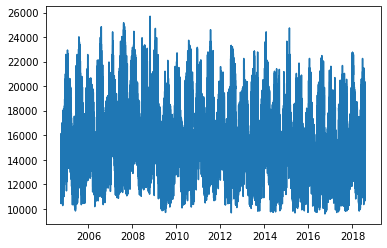

In [26]:
plt.plot(electricity_consumption['AEP_MW'])

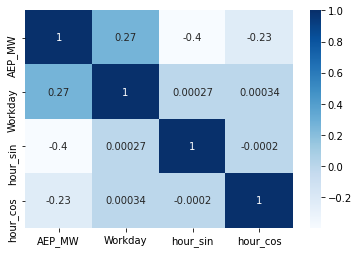

In [27]:
#Using Pearson Correlation function to determine correlation between our attributes and target variable
electricity_correlation = electricity_consumption.corr()
sns.heatmap(electricity_correlation, annot=True, cmap=plt.cm.Blues)
plt.show()

In [0]:
electricity_consumption = electricity_consumption[['Workday', 'hour_sin', 'hour_cos', 'AEP_MW']]

In [0]:
target_electro = electricity_consumption['AEP_MW']

In [30]:
stationarity_test(target_electro)

ADF test results:
Test Statistic                -1.830604e+01
p-value                        2.281284e-30
Lags Used                      7.100000e+01
Number of Observations Used    1.211970e+05
Critical Value(1%)            -3.430404e+00
Critical Value(5%)            -2.861564e+00
Critical Value(10%)           -2.566783e+00
dtype: float64
KPSS test results:
Test Statistic            6.939186
p-value                   0.010000
Lags Used               166.000000
Critical Value(10%)       0.347000
Critical Value(5%)        0.463000
Critical Value(2.5%)      0.574000
Critical Value(1%)        0.739000
dtype: float64


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1709: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


In [31]:
#Split electricity consumption into training/test sets of data (training 90% / 10% testing)
electricity_train = electricity_consumption[:int(electricity_consumption.shape[0]*0.9)]
electricity_test = electricity_consumption[int(electricity_consumption.shape[0]*0.9):]
electricity_train_arima = electricity_train['AEP_MW']
electricity_test_arima = electricity_test['AEP_MW']
print(electricity_train.shape, electricity_test.shape, electricity_train_arima.shape, electricity_test_arima.shape)

(109142, 4) (12127, 4) (109142,) (12127,)


##Section 2.2 - Traffic volume dataset

In [32]:
#We can use the date_time values to extract the same potentially helpful information, similarly to the electricity consumption dataset
traffic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday              48204 non-null  object 
 1   temp                 48204 non-null  float64
 2   rain_1h              48204 non-null  float64
 3   snow_1h              48204 non-null  float64
 4   clouds_all           48204 non-null  int64  
 5   weather_main         48204 non-null  object 
 6   weather_description  48204 non-null  object 
 7   date_time            48204 non-null  object 
 8   traffic_volume       48204 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 3.3+ MB


In [33]:
traffic.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


In [34]:
#Our dataset contains a categorical attribute "holiday". We can transform this to a numerical attribute
traffic['holiday'].value_counts()

None                         48143
Labor Day                        7
New Years Day                    6
Thanksgiving Day                 6
Martin Luther King Jr Day        6
Christmas Day                    6
Memorial Day                     5
State Fair                       5
Columbus Day                     5
Veterans Day                     5
Independence Day                 5
Washingtons Birthday             5
Name: holiday, dtype: int64

In [0]:
#We will encode holiday values to either 1 for holiday, or 0 for not
for i in range(len(traffic['holiday'])):
  if traffic['holiday'][i] == 'None':
    traffic['holiday'][i] = float(0)
  else:
    traffic['holiday'][i] = float(1)
traffic['holiday'] = traffic['holiday'].astype(float)

In [0]:
#We will also create new attribute to denote workdays as 1 and weekends as 0, similarly to traffic dataset
#We will also extract hour for each entry as a standalone attribute
traffic['date_time'] = pd.to_datetime(traffic['date_time'])
workdays = []
for date in traffic['date_time']:
  if date.weekday() > 4:
    workdays.append(0)
  else:
    workdays.append(1)
traffic['Workday'] = workdays
hours = traffic['date_time'].dt.hour
traffic['Hour'] = hours

In [0]:
#We will use cyclic representation to map the hour so that neural networks know that 23 and 0 hours are close
traffic['hour_sin'] = np.sin(traffic.Hour*(2.*np.pi/24))
traffic['hour_cos'] = np.cos(traffic.Hour*(2.*np.pi/24))
traffic.drop('Hour', axis=1, inplace=True)

In [38]:
#Basic description of all numerical data of traffic dataset
traffic.describe()

,holiday,temp,rain_1h,snow_1h,clouds_all,traffic_volume,Workday,hour_sin,hour_cos
count,48204.000000,48204.000000,48204.000000,48204.000000,48204.000000,48204.000000,48204.000000,4.820400e+04,4.820400e+04
mean,0.001265,281.205870,0.334264,0.000222,49.362231,3259.818355,0.715729,1.428336e-02,6.631123e-03
std,0.035551,13.338232,44.789133,0.008168,39.015750,1986.860670,0.451071,7.084205e-01,7.056296e-01
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000e+00,-1.000000e+00
25%,0.000000,272.160000,0.000000,0.000000,1.000000,1193.000000,0.000000,-7.071068e-01,-7.071068e-01
50%,0.000000,282.450000,0.000000,0.000000,64.000000,3380.000000,1.000000,1.224647e-16,6.123234e-17
75%,0.000000,291.806000,0.000000,0.000000,90.000000,4933.000000,1.000000,7.071068e-01,7.071068e-01
max,1.000000,310.070000,9831.300000,0.510000,100.000000,7280.000000,1.000000,1.000000e+00,1.000000e+00


In [0]:
#We can see that temp values, which are measured in Kelvin, have 0 values
#This is an error, since 0K is approx. -273 degress Celsius. To fix these values,
#we will replace them by values from the same time on previous day
temp_var = traffic.index[traffic['temp'] == 0].tolist()
for index in temp_var:
  traffic['temp'][index] = traffic['temp'][index - 24]

In [40]:
#We will quickly check each of the original attributes for missing values
traffic.holiday.isna().value_counts()

False    48204
Name: holiday, dtype: int64

In [41]:
traffic.temp.isna().value_counts()

False    48204
Name: temp, dtype: int64

In [42]:
traffic.rain_1h.isna().value_counts()

False    48204
Name: rain_1h, dtype: int64

In [43]:
traffic.snow_1h.isna().value_counts()

False    48204
Name: snow_1h, dtype: int64

In [44]:
traffic.clouds_all.isna().value_counts()

False    48204
Name: clouds_all, dtype: int64

In [45]:
traffic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   holiday              48204 non-null  float64       
 1   temp                 48204 non-null  float64       
 2   rain_1h              48204 non-null  float64       
 3   snow_1h              48204 non-null  float64       
 4   clouds_all           48204 non-null  int64         
 5   weather_main         48204 non-null  object        
 6   weather_description  48204 non-null  object        
 7   date_time            48204 non-null  datetime64[ns]
 8   traffic_volume       48204 non-null  int64         
 9   Workday              48204 non-null  int64         
 10  hour_sin             48204 non-null  float64       
 11  hour_cos             48204 non-null  float64       
dtypes: datetime64[ns](1), float64(6), int64(3), object(2)
memory usage: 4.4+ MB


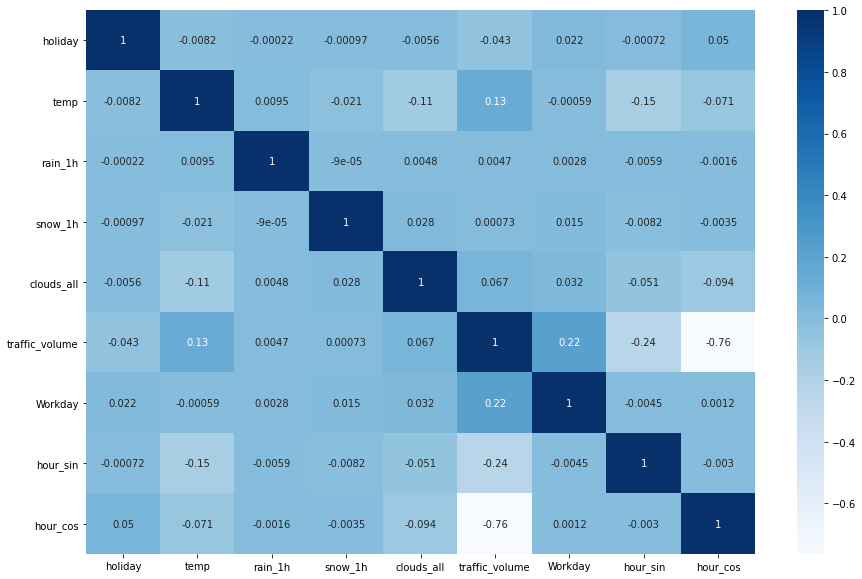

In [46]:
#Seems we dont have any missing values. We can calculate Pearson correlation coeficients for our values
#We can see strong negative correlation between cosine value of hour and our target variable, the traffic volume
#Also small positive correlation is present between target variable and workday and temp variables, while
#negative correlation is seen with sine value of hour
#Since other values dont present a lot of correlation, we will drop them
traffic_correlation = traffic.corr()
plt.subplots(figsize=(15,10))
sns.heatmap(traffic_correlation, annot=True, cmap=plt.cm.Blues)
plt.show()

In [0]:
#We will use only the following attributes:
#Sine representation of hour
#Cosine representation of hour
#Workday attribute denoting workdays as 0 and weekends as 1
#Target values traffic_volume
traffic = traffic[['hour_sin', 'hour_cos', 'Workday', 'traffic_volume']]

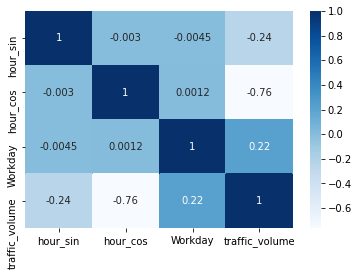

In [48]:
#Correlation map after removing unnecessary attributes
traffic_correlation = traffic.corr()
plt.subplots()
sns.heatmap(traffic_correlation, annot=True, cmap=plt.cm.Blues)
plt.show()

In [0]:
#Split dataset into training/testing sets
traffic = traffic.astype(float)
traffic_train = traffic[:int(traffic.shape[0]*0.9)]
traffic_test = traffic[int(traffic.shape[0]*0.9):]
traffic_train_arima = traffic_train['traffic_volume']
traffic_test_arima = traffic_test['traffic_volume']

In [50]:
print(traffic_train.shape, traffic_test.shape, traffic_train_arima.shape, traffic_test_arima.shape)

(43383, 4) (4821, 4) (43383,) (4821,)


#Section 3 - Model implementation and training functions

In [51]:
#Print information about used hardware
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 298673305590819735
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 14075643710438356446
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 13521603017458776735
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11150726272
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8917651938468217739
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]
Default GPU Device: /device:GPU:0


In [0]:
#Here our models are created
#Number of units,layers have to be adjusted manually here
def create_model(layer_type, future_timesteps, x_shape):
  model = Sequential()
  if layer_type == 'lstm':
    model.add(LSTM(units=96))
    model.add(Dropout(0.3))
    model.add(Dense(units=future_timesteps, activation='linear'))   
  elif layer_type == 'lstm_stacked':
    model.add(LSTM(units=48, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=48, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=32))
    model.add(Dense(units=future_timesteps, activation='linear'))
  elif layer_type == 'bidirectional':
    model.add(Bidirectional(LSTM(units=96)))
    model.add(Dropout(0.2))
    model.add(Dense(units=future_timesteps, activation='linear'))
  elif layer_type == 'gru':
    model.add(GRU(units=64))
    model.add(Dense(units=future_timesteps, activation='linear'))
  elif layer_type == 'gru_stacked':
    model.add(GRU(units=64, return_sequences=True))
    model.add(GRU(units=64))
    model.add(Dense(units=future_timesteps, activation='linear'))
  elif layer_type == 'autoencoder':
    shape_temp = 1
    if len(x_shape) == 3:
      shape_temp = x_shape[2]
    model.add(LSTM(64, input_shape=(history_timesteps, shape_temp)))
    model.add(RepeatVector(future_timesteps))
    model.add(LSTM(64, return_sequences=True))
    model.add(TimeDistributed(Dense(48, activation='linear')))
    model.add(TimeDistributed(Dense(1)))
    
  opt = tf.keras.optimizers.Adam(lr=0.00025)
  model.compile(loss='mean_squared_error', optimizer=opt)
  return model

In [0]:
#Function to fit trained model using defined callbacks, also plots loss function progression
def fit_model(model, Xs, Ys, num_epochs, num_batch_size):
  earlyStopping = EarlyStopping(monitor='val_loss', patience=9, verbose=0, mode='min')
  mcp_save = ModelCheckpoint('/content/drive/My Drive/best_model.hdf5',save_best_only=True, verbose=1, monitor='val_loss', mode='min')
  reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, min_delta=2e-04, mode='auto')
  history = model.fit(Xs, Ys, epochs=num_epochs, batch_size=num_batch_size, validation_split=0.2, callbacks=[earlyStopping, mcp_save, reduce_lr_loss],verbose=1, shuffle=True)
  plt.plot(history.history['loss'], label='Train loss')
  plt.plot(history.history['val_loss'], label='Validation loss')
  plt.legend()
  plt.show()

In [0]:
#Implementation of ARIMA function using rpy2 library to combine it with this .ipynb file
def arima_fit_predict(x_train_arima, x_test_arima, x_test_arima_fulltest, future_timesteps):
  #Check if necessary libraries are installed
  package_name = "forecast"
  try:
    pkg = importr(package_name)
  except:
    print('Installing forecast package')
    robjects.r(f'install.packages("{package_name}", quiet=TRUE)')
    pkg = importr(package_name)
  ts = robjects.r('ts')
  forecast = importr('forecast')
  print("Forecast imported, starting fit and forecast fuction(long run time, around 2 hours)")
  
  arima_fit_func = """
    function(x_train_arima, x_test_arima, future_timesteps, predictions_arima){
        print(123456)
        print(dim(x_test_arima))
        arima_model = auto.arima(ts(x_train_arima, frequency=24), max.p=20)
        print(arima_model)
        print('Generating ARIMA predictions for each sequence')
        for (input_sequence in 1:nrow(x_test_arima)){
          temp <- forecast(x_test_arima[input_sequence,], h=future_timesteps, model=arima_model)
          predictions_arima <- append(predictions_arima, as.numeric(temp$mean))
        }
      print('Arima predictions generated')
      return(predictions_arima)
    }
  """
  #Create, fit ARIMA and produce results, then reshape them before returning
  rfunc=robjects.r(arima_fit_func)
  predictions_arima = list()
  predictions_arima_listvector = rfunc(x_train_arima, x_test_arima.reshape(x_test_arima.shape[0], x_test_arima.shape[1]), future_timesteps, predictions_arima)
  arima_predictions_nonformatted = np.asarray(pd.DataFrame(data=[i[0] for i in predictions_arima_listvector]))
  arima_predictions_formatted = arima_predictions_nonformatted.reshape(int(arima_predictions_nonformatted.shape[0]/future_timesteps), future_timesteps)
  return arima_predictions_formatted

#Section 4 - Result evaluation functions

In [0]:
#Calculates MSE, MAE and RMSE values for each sequence into lists, then returns mean of these lists
def calculate_results(real_values, predicted_values):
  mae_list = []
  mse_list = []
  for i in range(real_values.shape[0]):
    mse_list.append(mean_squared_error(real_values[i], predicted_values[i]))
    mae_list.append(mean_absolute_error(real_values[i], predicted_values[i]))
  mean_mse = sum(mse_list)/len(mse_list)
  mean_mae = sum(mae_list)/len(mae_list)
  return mean_mse, mean_mae, math.sqrt(mean_mse)

In [0]:
#Function to initialize calculation of results and print them, only works with available values
def get_results(real_values, predicted_neural, predicted_arima, predicted_linreg, predicted_regressive):
  print('Result order: MSE | MAE | RMSE')
  if predicted_neural is not None:
    print('Neural networks: ', calculate_results(real_values, predicted_neural))
  if predicted_linreg is not None:
    print('Linear regression: ', calculate_results(real_values, predicted_linreg))
  if predicted_arima is not None:
    print('Arima: ', calculate_results(real_values, predicted_arima))
  if predicted_regressive is not None:
    print('Regressive neural: ', calculate_results(real_values, predicted_regressive))

#Section 5 - Prediction functions

In [0]:
#Function implementing autoregressive forecasting, with following steps:
#1 - A future value is predicted for every input sequence
#2 - Every input sequence is rolled, meaning that values at each index are moved to index lowered by 1
#3 - Last value of every input sequence is replaced by corresponding predicted value
#4 - Repeat from step 1, stop when every value needed is predicted
#Predictions are appended to results, which are then returned for comparison
def predict_values_autoregressive_type(model, x_test, future_timesteps):
  ss_results = np.array([])
  #Repeat for full length of forecast
  for i in range(future_timesteps):
    predicted = model.predict(x_test)
    #Save predicted value, add it to input sequence for next prediction
    for row in range(predicted.shape[0]):
      x_test[row] = np.roll(x_test[row], -1, axis=0) 
      x_test[row][-1][-1] = predicted[row][0]
      #add corresponding values for attributes
      if row < predicted.shape[0]-1:
        for attrib in range(x_test.shape[2]):
          x_test[row][-1][attrib] = x_test[row+1][0][attrib]
  return ss_results

In [0]:
#Updated version of autoregressive function
#This function works similarly to oneshot type prediction, it forecasts full sequence
#and then takes the first value of this sequence to use for forecasting the subsequent one
#and repeats until all outputs are predicted
def predict_values_autoregressive_type_evolved(model, x_test, future_timesteps):
  ss_results = np.array([])
  #Repeat for full length of forecast
  for i in range(future_timesteps):
    predicted_regressive_single = model.predict(x_test)
    #Save predicted value, add it to input sequence for next prediction
    for sequence in range(predicted_regressive_single.shape[0]):
      ss_results = np.append(ss_results, predicted_regressive_single[sequence][0])
      x_test[sequence] = np.roll(x_test[sequence], -1, axis=0) 
      x_test[sequence][-1][-1] = predicted_regressive_single[sequence][0]
      #add corresponding values for attributes
      if sequence < predicted_regressive_single.shape[0]-1:
        for attrib in range(x_test.shape[2]):
          x_test[sequence][-1][attrib] = x_test[sequence+1][0][attrib]
  ss_results = ss_results.reshape(-1, future_timesteps, order='F')
  return ss_results

In [0]:
#Simple linear regression implementation as baseline model
def predict_values_linreg(x_train, y_train, x_test, y_test):
  linreg_model = linear_model.LinearRegression()
  linreg_model.fit(x_train, y_train)
  linreg_preds = linreg_model.predict(x_test)
  return linreg_preds

In [0]:
def create_predictions(input_type, prediction_type, layer_type, history_timesteps, future_timesteps, num_epochs, num_batch_size, train_data, train_data_labels, test_data, test_data_labels):
  x_train, y_train = prepare_input_output_data(train_data, train_data_labels, history_timesteps, future_timesteps)
  x_test, y_test = prepare_input_output_data(test_data, test_data_labels, history_timesteps, future_timesteps)
  linreg_predictions, arima_predictions, predictions, predictions_regressive = None, None, None, None
  print('Training Xs and Ys shape: ', x_train.shape, y_train.shape,' ||| Testing Xs and Ys shape: ', x_test.shape, y_test.shape)
  #Run linear regression forecasts
  if input_type == 'univariate' and run_linregress is not False:
    linreg_predictions = predict_values_linreg(x_train.reshape(x_train.shape[0],x_train.shape[1]), y_train.reshape(y_train.shape[0],y_train.shape[1]), x_test.reshape(x_test.shape[0], x_test.shape[1]), y_test.reshape(y_test.shape[0],y_test.shape[1]))
  elif run_linregress is True:
    linreg_predictions = predict_values_linreg(x_train.reshape(x_train.shape[0],x_train.shape[1]*x_train.shape[2]), y_train, x_test.reshape(x_test.shape[0], x_test.shape[1]*x_test.shape[2]), y_test)  

  #Run ARIMA, only work with univariate input(ARIMA only takes univariate)
  if run_arima is True and input_type == 'univariate':
    arima_predictions = arima_fit_predict(train_data_labels, x_test, test_data_labels, future_timesteps)

  if run_neurals is True:
    #Autoregressive only predictions
    if prediction_type == 'autoregressive':
      print('Autoregressive type')
      model = create_model(layer_type, 1, x_train.shape)
      fit_model(model, x_train, y_train, num_epochs, num_batch_size)
      print('Model is compiled and fit')
      model = load_model('/content/drive/My Drive/best_model.hdf5')
      predictions = predict_values_autoregressive_type(model, x_test, future_timesteps)
      predictions = predictions.reshape(int(predictions.shape[0]/future_timesteps),future_timesteps)
    else:
      #Evolved autoregressive and oneshot predictions
      print('Oneshot type')
      model = create_model(layer_type, future_timesteps, x_train.shape)
      fit_model(model, x_train, y_train, num_epochs, num_batch_size)
      print('Model is compiled and fit')
      model = load_model('/content/drive/My Drive/best_model.hdf5')
      predictions = model.predict(x_test, future_timesteps)
      predictions_regressive = predict_values_autoregressive_type_evolved(model, x_test, future_timesteps)
      predictions = predictions.reshape(int(predictions.shape[0]),future_timesteps)

  return predictions, y_test, linreg_predictions, arima_predictions, predictions_regressive

In [0]:
#Initializes prediction creation 
def get_predictions():
  print('Dataset: '+dataset+' ,type: '+input_type)
  if dataset == 'traffic':
    if input_type == 'univariate':
      train_data, test_data, train_data_labels, test_data_labels, target_scaler, train_data_arima, test_data_arima = univariate_data(traffic_train, traffic_test, traffic_train_arima, traffic_test_arima, 'traffic_volume')
    else:
      train_data, test_data, train_data_labels, test_data_labels, target_scaler, train_data_arima, test_data_arima = multivariate_traffic_data(traffic_train, traffic_test, traffic_train_arima, traffic_test_arima)
  elif dataset == 'electricity':
    if input_type == 'univariate':
      train_data, test_data, train_data_labels, test_data_labels, target_scaler, train_data_arima, test_data_arima = univariate_data(electricity_train, electricity_test, electricity_train_arima, electricity_test_arima, 'AEP_MW')
    else:
     train_data, test_data, train_data_labels, test_data_labels, target_scaler, train_data_arima, test_data_arima = multivariate_eletricity_data(electricity_train, electricity_test, electricity_train_arima, electricity_test_arima)

  predictions, real_values, linreg_predictions, arima_predictions, predictions_regressive = create_predictions(input_type, prediction_type, model_type, history_timesteps, future_timesteps, num_epochs, num_batch_size, train_data, train_data_labels, test_data, test_data_labels)
  return real_values, predictions, linreg_predictions, arima_predictions, predictions_regressive

#Section 6 - Main

In [0]:
#Change parameter settings here
#Change parameters, then run all to take effects
#Specify number of time steps(length of input sequences) to train on
history_timesteps = 24*30
#Specify number of time steps(length of output sequences) to predict
future_timesteps = 24*3
dataset = 'electricity' #electricity or traffic
#Specify input type for neural networks:
  #univariate - Networks only have one attribute -> the target attribute we want to predict values for
  #multivariate - Use all available attributes 
input_type = 'multivariate'
#Specify number of epochs for neural network training
num_epochs = 500
#Specify the number of batch size during neural network training
num_batch_size = 16
#Specify prediction type:
  #oneshot - outputs both the oneshot and evolved autoregressive function results
  #autoregressive - only outputs the autoregressive function results, forecasts single value, then uses it to forecast another
prediction_type = 'oneshot'
#Specify which model of neural networks to run. Options:
  #lstm, stacked_lstm, gru, stacked_gru, bidirectional, autoencoder
model_type = 'bidirectional'
#Specify which models to run ( True to run, False to not run)
run_arima = False
run_linregress = True
run_neurals = True

In [0]:
real_values, predictions, linreg_predictions, arima_predictions, predictions_regressive = get_predictions()

In [0]:
get_results(real_values, predictions, arima_predictions, linreg_predictions, predictions_regressive)

In [0]:
#Plot predictions and real values from available models
seq = 123
if linreg_predictions is not None:
  plt.plot(linreg_predictions[seq], label='linreg')
if predictions is not None:
  plt.plot(predictions[seq], label='neural')
if arima_predictions is not None:
  plt.plot(arima_predictions[seq], label='arima')
if predictions_regressive is not None:
  plt.plot(predictions_regressive[seq], label='neural regressive')
plt.plot(real_values[seq], label='real')
plt.legend()